#Style Transfer

The objective of this project is to train images with the Pre-trained MSG-Net, a neural style transfer model, for generating visual representations of fungi diversity in real-time.

Code Reference:
https://computervisionrutgers.github.io/MSG-Net/

https://colab.research.google.com/github/zhanghang1989/PyTorch-Multi-Style-Transfer/blob/master/msgnet.ipynb#scrollTo=bqO1brl1LumW

Dataset used: https://www.kaggle.com/datasets/mdwaquarazam/microorganism-image-classification

# Style transfered images


In [ ]:
# import numpy & pytorch
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable


# define Gram Matrix
class GramMatrix(nn.Module):
    def forward(self, y):
        (b, ch, h, w) = y.size()
        features = y.view(b, ch, w * h)
        features_t = features.transpose(1, 2)
        gram = features.bmm(features_t) / (ch * h * w)
        return gram


# proposed Inspiration(CoMatch) Layer
class Inspiration(nn.Module):
    """ Inspiration Layer (from MSG-Net paper)
    tuning the featuremap with target Gram Matrix
    ref https://arxiv.org/abs/1703.06953
    """
    def __init__(self, C, B=1):
        super(Inspiration, self).__init__()
        # B is equal to 1 or input mini_batch
        self.weight = nn.Parameter(torch.Tensor(1, C, C), requires_grad=True)
        # non-parameter buffer
        self.G = Variable(torch.Tensor(B, C, C), requires_grad=True)
        self.C = C
        self.reset_parameters()

    def reset_parameters(self):
        self.weight.data.uniform_(0.0, 0.02)

    def setTarget(self, target):
        self.G = target

    def forward(self, X):
        # input X is a 3D feature map
        self.P = torch.bmm(self.weight.expand_as(self.G), self.G)
        return torch.bmm(self.P.transpose(1, 2).expand(X.size(0), self.C, self.C),
                         X.view(X.size(0), X.size(1), -1)).view_as(X)

    def __repr__(self):
        return self.__class__.__name__ + '(' + 'N x ' + str(self.C) + ')'


# some basic layers, with reflectance padding
class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = kernel_size // 2
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out


class UpsampleConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride,
                 upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        if upsample:
            self.upsample_layer = torch.nn.Upsample(scale_factor=upsample)
        self.reflection_padding = kernel_size // 2
        if self.reflection_padding != 0:
            self.reflection_pad = nn.ReflectionPad2d(self.reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        if self.upsample:
            x = self.upsample_layer(x)
        if self.reflection_padding != 0:
            x = self.reflection_pad(x)
        out = self.conv2d(x)
        return out


class Bottleneck(nn.Module):
    """ Pre-activation residual block
    Identity Mapping in Deep Residual Networks
    ref https://arxiv.org/abs/1603.05027
    """
    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 norm_layer=nn.BatchNorm2d):
        super(Bottleneck, self).__init__()
        self.expansion = 4
        self.downsample = downsample
        if self.downsample is not None:
            self.residual_layer = nn.Conv2d(inplanes, planes*self.expansion,
                                            kernel_size=1, stride=stride)
        conv_block = []
        conv_block += [norm_layer(inplanes),
                       nn.ReLU(inplace=True),
                       nn.Conv2d(inplanes, planes, kernel_size=1, stride=1)]
        conv_block += [norm_layer(planes),
                       nn.ReLU(inplace=True),
                       ConvLayer(planes, planes, kernel_size=3, stride=stride)]
        conv_block += [norm_layer(planes),
                       nn.ReLU(inplace=True),
                       nn.Conv2d(planes, planes*self.expansion, kernel_size=1,
                                 stride=1)]
        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        if self.downsample is not None:
            residual = self.residual_layer(x)
        else:
            residual = x
        return residual + self.conv_block(x)


class UpBottleneck(nn.Module):
    """ Up-sample residual block (from MSG-Net paper)
    Enables passing identity all the way through the generator
    ref https://arxiv.org/abs/1703.06953
    """
    def __init__(self, inplanes, planes, stride=2, norm_layer=nn.BatchNorm2d):
        super(UpBottleneck, self).__init__()
        self.expansion = 4
        self.residual_layer = UpsampleConvLayer(inplanes, planes*self.expansion,
                                                kernel_size=1, stride=1,
                                                upsample=stride)
        conv_block = []
        conv_block += [norm_layer(inplanes),
                       nn.ReLU(inplace=True),
                       nn.Conv2d(inplanes, planes, kernel_size=1, stride=1)]
        conv_block += [norm_layer(planes),
                       nn.ReLU(inplace=True),
                       UpsampleConvLayer(planes, planes, kernel_size=3,
                                         stride=1, upsample=stride)]
        conv_block += [norm_layer(planes),
                       nn.ReLU(inplace=True),
                       nn.Conv2d(planes, planes*self.expansion, kernel_size=1,
                                 stride=1)]
        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return self.residual_layer(x) + self.conv_block(x)


# the MSG-Net
class Net(nn.Module):
    def __init__(self, input_nc=3, output_nc=3, ngf=64,
                 norm_layer=nn.InstanceNorm2d, n_blocks=6, gpu_ids=[]):
        super(Net, self).__init__()
        self.gpu_ids = gpu_ids
        self.gram = GramMatrix()

        block = Bottleneck
        upblock = UpBottleneck
        expansion = 4

        model1 = []
        model1 += [ConvLayer(input_nc, 64, kernel_size=7, stride=1),
                   norm_layer(64),
                   nn.ReLU(inplace=True),
                   block(64, 32, 2, 1, norm_layer),
                   block(32*expansion, ngf, 2, 1, norm_layer)]
        self.model1 = nn.Sequential(*model1)

        model = []
        self.ins = Inspiration(ngf*expansion)
        model += [self.model1]
        model += [self.ins]

        for i in range(n_blocks):
            model += [block(ngf*expansion, ngf, 1, None, norm_layer)]

        model += [upblock(ngf*expansion, 32, 2, norm_layer),
                  upblock(32*expansion, 16, 2, norm_layer),
                  norm_layer(16*expansion),
                  nn.ReLU(inplace=True),
                  ConvLayer(16*expansion, output_nc, kernel_size=7, stride=1)]

        self.model = nn.Sequential(*model)

    def setTarget(self, Xs):
        f = self.model1(Xs)
        G = self.gram(f)
        self.ins.setTarget(G)

    def forward(self, input):
        return self.model(input)

In [ ]:
from PIL import Image


def tensor_load_rgbimage(filename, size=None, scale=None, keep_asp=False):
    img = Image.open(filename).convert('RGB')
    if size is not None:
        if keep_asp:
            size2 = int(size * 1.0 / img.size[0] * img.size[1])
            img = img.resize((size, size2), Image.ANTIALIAS)
        else:
            img = img.resize((size, size), Image.ANTIALIAS)

    elif scale is not None:
        img = img.resize((int(img.size[0] / scale), int(img.size[1] / scale)),
                         Image.ANTIALIAS)
    img = np.array(img).transpose(2, 0, 1)
    img = torch.from_numpy(img).float()
    return img


def tensor_save_rgbimage(tensor, filename, cuda=False):
    if cuda:
        img = tensor.clone().cpu().clamp(0, 255).numpy()
    else:
        img = tensor.clone().clamp(0, 255).numpy()
    img = img.transpose(1, 2, 0).astype('uint8')
    img = Image.fromarray(img)
    img.save(filename)


def tensor_save_bgrimage(tensor, filename, cuda=False):
    (b, g, r) = torch.chunk(tensor, 3)
    tensor = torch.cat((r, g, b))
    tensor_save_rgbimage(tensor, filename, cuda)


def preprocess_batch(batch):
    batch = batch.transpose(0, 1)
    (r, g, b) = torch.chunk(batch, 3)
    batch = torch.cat((b, g, r))
    batch = batch.transpose(0, 1)
    return batch

In [ ]:
!wget -q -O 21styles.model https://www.dropbox.com/s/2iz8orqqubrfrpo/21styles.model?dl=1

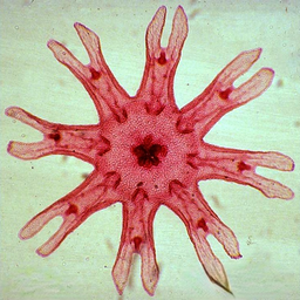

In [ ]:
display(Image.open('/content/drive/MyDrive/style image/Hydra_47.png').resize((300, 300)))

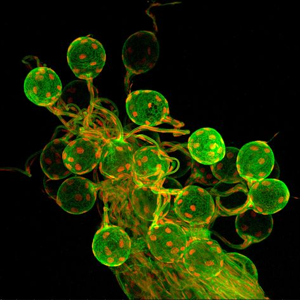

In [ ]:
display(Image.open('/content/drive/MyDrive/style image/style10.jpeg').resize((300, 300)))

In [ ]:
content_image = tensor_load_rgbimage('/content/drive/MyDrive/style image/Hydra_47.png', size=512,
                                     keep_asp=True).unsqueeze(0)
style = tensor_load_rgbimage('/content/drive/MyDrive/style image/style10.jpeg', size=512).unsqueeze(0)
style = preprocess_batch(style)

<ipython-input-2-d89ee6a8c96c>:9: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((size, size2), Image.ANTIALIAS)
<ipython-input-2-d89ee6a8c96c>:11: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((size, size), Image.ANTIALIAS)


In [ ]:
style_model = Net(ngf=128)
model_dict = torch.load('21styles.model')
model_dict_clone = model_dict.copy()
for key, value in model_dict_clone.items():
    if key.endswith(('running_mean', 'running_var')):
        del model_dict[key]
style_model.load_state_dict(model_dict, False)

<All keys matched successfully>

In [ ]:
style_v = Variable(style)
content_image = Variable(preprocess_batch(content_image))
style_model.setTarget(style_v)
output = style_model(content_image)
tensor_save_bgrimage(output.data[0], 'output.jpg', False)

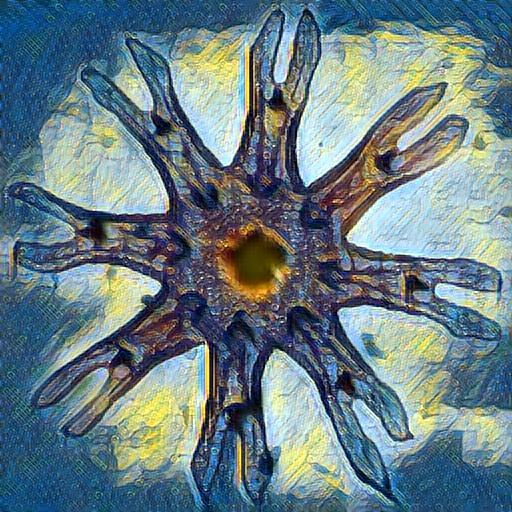

In [ ]:
display(Image.open('output.jpg'))

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d sachinkumar413/microorganism-preprocessed-images-dataset

 98% 76.0M/77.5M [00:05<00:00, 19.6MB/s]
100% 77.5M/77.5M [00:05<00:00, 14.9MB/s]


In [ ]:
! unzip microorganism-preprocessed-images-dataset.zip

Archive:  microorganism-preprocessed-images-dataset.zip
  inflating: Amoeba/Amoeba.png       
  inflating: Amoeba/Amoeba_10.png    
  inflating: Amoeba/Amoeba_11.png    
  inflating: Amoeba/Amoeba_12.png    
  inflating: Amoeba/Amoeba_13.png    
  inflating: Amoeba/Amoeba_14.png    
  inflating: Amoeba/Amoeba_15.png    
  inflating: Amoeba/Amoeba_16.png    
  inflating: Amoeba/Amoeba_17.png    
  inflating: Amoeba/Amoeba_18.png    
  inflating: Amoeba/Amoeba_19.png    
  inflating: Amoeba/Amoeba_2.png     
  inflating: Amoeba/Amoeba_20.png    
  inflating: Amoeba/Amoeba_21.png    
  inflating: Amoeba/Amoeba_22.png    
  inflating: Amoeba/Amoeba_23.png    
  inflating: Amoeba/Amoeba_24.png    
  inflating: Amoeba/Amoeba_25.png    
  inflating: Amoeba/Amoeba_26.png    
  inflating: Amoeba/Amoeba_27.png    
  inflating: Amoeba/Amoeba_28.png    
  inflating: Amoeba/Amoeba_29.png    
  inflating: Amoeba/Amoeba_3.png     
  inflating: Amoeba/Amoeba_30.png    
  inflating: Amoeba/Amoeba_31.pn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from torchvision.utils import save_image


content_dir = '/content/fungi2'
output_dir = '/content/out'
model_path = '/content/21styles.model'
style_image_path='/content/drive/MyDrive/style image/style10.jpeg'

# 确保输出目录存在
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 加载风格模型和风格图像
style_model = Net(ngf=128)
model_dict = torch.load(model_path)
model_dict_clone = model_dict.copy()
for key, value in model_dict_clone.items():
    if key.endswith(('running_mean', 'running_var')):
        del model_dict[key]
style_model.load_state_dict(model_dict, False)
style = tensor_load_rgbimage(style_image_path, size=512).unsqueeze(0)
style = preprocess_batch(style)
style_v = Variable(style)
style_model.setTarget(style_v)

# 遍历内容图像并进行风格迁移
for content_img_name in os.listdir(content_dir):
    content_img_path = os.path.join(content_dir, content_img_name)
    output_img_path = os.path.join(output_dir, content_img_name)

    content_image = tensor_load_rgbimage(content_img_path, size=512, keep_asp=True).unsqueeze(0)
    content_image = Variable(preprocess_batch(content_image))
    output = style_model(content_image)
    tensor_save_bgrimage(output.data[0], output_img_path, False)

<ipython-input-2-d89ee6a8c96c>:11: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((size, size), Image.ANTIALIAS)
<ipython-input-2-d89ee6a8c96c>:9: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((size, size2), Image.ANTIALIAS)


In [ ]:
import os
from torchvision.utils import save_image
from torchvision import transforms

content_dir = '/content/fungi'
output_dir = '/content/out'
model_path = '/content/21styles.model'
style_image_path = '/content/drive/MyDrive/style image/style10.jpeg'

# Sets the size of the images. In this case, both height and width of the images will be resized to 512 pixels.
target_size = 512

# 确保输出目录存在
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# load the pre-trained model
style_model = Net(ngf=128)
model_dict = torch.load(model_path)
model_dict_clone = model_dict.copy()
for key, value in model_dict_clone.items():
    if key.endswith(('running_mean', 'running_var')):
        del model_dict[key]
style_model.load_state_dict(model_dict, False)
style = tensor_load_rgbimage(style_image_path, size=target_size).unsqueeze(0)
style = preprocess_batch(style)
style_v = Variable(style)
style_model.setTarget(style_v)

transform = transforms.Compose([
    transforms.Resize((target_size, target_size)),
])

# This loop goes through each image in the content_dir, applies the style transfer, and saves the output
for content_img_name in os.listdir(content_dir):
    content_img_path = os.path.join(content_dir, content_img_name)
    output_img_path = os.path.join(output_dir, content_img_name)

    content_image = tensor_load_rgbimage(content_img_path, keep_asp=True).unsqueeze(0)
    content_image = transform(content_image)
    content_image = Variable(preprocess_batch(content_image))
    output = style_model(content_image)
    tensor_save_bgrimage(output.data[0], output_img_path, False)


<ipython-input-89-d89ee6a8c96c>:11: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((size, size), Image.ANTIALIAS)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
